In [8]:
# General stuff
import os
import re
import time
import warnings
import math
import sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
from IPython.core.debugger import Tracer
from nilearn.decomposition import CanICA,DictLearning
from sklearn.decomposition import DictionaryLearning
from mpl_toolkits.mplot3d import axes3d, Axes3D 

# sklearn stuff
from sklearn.decomposition import TruncatedSVD,FastICA,SparsePCA,MiniBatchSparsePCA
from sklearn.utils.extmath import randomized_svd
from sklearn.linear_model import Ridge
from sklearn.decomposition import dict_learning_online
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import scale
import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import _hc_cut # Internal function to cut ward tree, helps speed up things a lot
from sklearn.utils import resample
from sklearn.model_selection import KFold

# personal functions
from importlib import reload
import fsutils as fs
reload(fs)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Documents/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknown location')
    
# Load local version of nilearn
if os.path.exists('/data1/vbeliveau/'):
    sys.path.append('/data1/vbeliveau/nilearn')
    import mynilearn.decomposition as dcm 
    reload(dcm)
elif os.path.exists('C:/Users/vbeliveau/'):
    sys.path.append('C:/Users/vbeliveau/Downloads/nilearn-master')
    import mynilearn.decomposition as dcm
    reload(dcm)
else:
    raise ValueError('Unknown location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
fs.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
fs.assert_dir(BPnd_data)
MFA_data=opj(cluster_data,'MFA')
MFA_preproc=opj(MFA_data,'preproc')
fs.assert_dir(MFA_data)
fs.assert_dir(MFA_preproc)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=[item for subl in info['petID'] for subsubl in subl for item in subsubl]

In [ ]:
# Compare components obtained with SVD and truncated SVD
# Here PCA is used as the gold standard (full, accurate decomposition)
# and truncated SVD is performed with some variations

from sklearn.decomposition import PCA

tracer='cumi'
preproc=np.load(opj(MFA_data,tracer,'preproc.fsaverage5.sm5.npz'))
data=preproc['arr_0']
data=np.hstack(data) # Use whole dataset

Kmax=20
U,S,V=np.linalg.svd(data,full_matrices=False)

def print_corr(A,B,Kmax):
    for i in np.arange(0,Kmax):
        cc=np.zeros(Kmax)
        for j in np.arange(0,Kmax):
            cc[j]=abs(np.dot(np.transpose(A[:,i]),B[:,j]))
        print('Component ' + str(i+1) + ': %f' % np.max(cc))
    
# Trunk SVD from PCA
print('Truncated SVD with PCA')
pca=PCA(n_components=Kmax)
pca.fit(np.transpose(data))
print_corr(np.transpose(pca.components_),U,Kmax)

# Trunk SVD from TruncatedSVD with random the randomized algorithm (default)
print('\nTruncated SVD with randomized')
svd1=TruncatedSVD(n_components=Kmax)
svd1.fit(np.transpose(data))
print_corr(np.transpose(svd1.components_),U,Kmax)

# Trunk SVD from TruncatedSVD with ARPACK algorithm
print('\nTruncated SVD with ARPACK')
svd2=TruncatedSVD(n_components=Kmax,algorithm='arpack')
svd2.fit(np.transpose(data))
print_corr(np.transpose(svd2.components_),U,Kmax)

[-0.58054199 -0.05898944  0.81209066]
-0.0725116293275
-4.15461032608
[ -5.80541987e-01  -4.92661467e-16   8.14230312e-01]


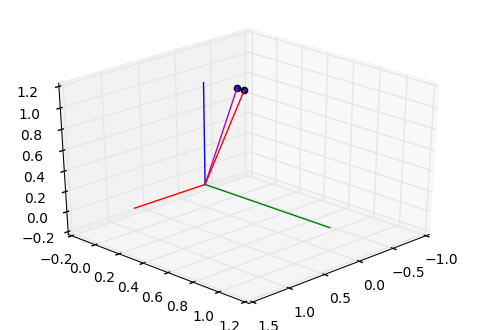

-35.6992992013


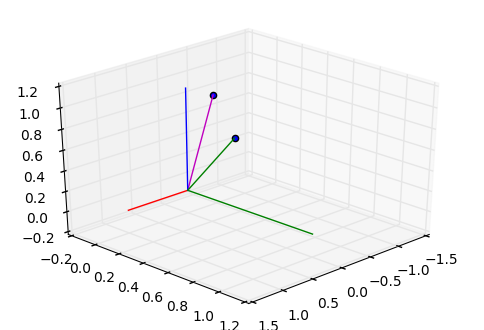

35.4886721623
[  0.00000000e+00  -4.92661467e-16   1.00000000e+00]


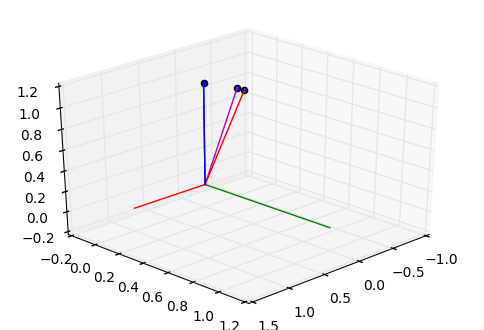

In [10]:
# Testing rotations used for computing surface gradient

v=np.random.normal(size=3)
v=v/np.linalg.norm(v)
print(v)

vx=np.array([1.,0.,0.])
vy=np.array([0.,1.,0.])
vz=np.array([0.,0.,1.])

def plot_axes_vec():
    fig = plt.figure()
    h  = fig.add_subplot(111, projection = '3d')
    h.scatter(v[0],v[1],v[2])
    h.plot([0,v[0]],[0,v[1]],[0,v[2]], color = 'm')
    h.plot([0,vx[0]],[0,vx[1]],[0,vx[2]], color = 'r')
    h.plot([0,vy[0]],[0,vy[1]],[0,vy[2]], color = 'g')
    h.plot([0,vz[0]],[0,vz[1]],[0,vz[2]], color = 'b')
    h.view_init(30, 45)
    return h
    
# Rotate along y
rx=fs.vec_angle(vz,np.array([0,v[1],v[2]]))
if v[1]<0:
    rx=-rx
print(rx)
    
print(rx*180/np.pi)
vrx=fs.rotate3d(v,rx,axis=0,compute=True)
print(vrx)

h=plot_axes_vec()
h.scatter(vrx[0],vrx[1],vrx[2])
h.plot([0,vrx[0]],[0,vrx[1]],[0,vrx[2]], color = 'r')
plt.show()

# Rotate along y
ry=-fs.vec_angle(vz,v)
print(ry*180/np.pi)
vry=fs.rotate3d(v,ry,axis=1,compute=True)

h=plot_axes_vec()
h.scatter(vry[0],vry[1],vry[2])
h.plot([0,vry[0]],[0,vry[1]],[0,vry[2]], color = 'g')
plt.show()

# Rotate along y
ry=fs.vec_angle(vz,vrx)
if vrx[0]>0:
    ry=-ry
print(ry*180/np.pi)
vry=fs.rotate3d(vrx,ry,axis=1,compute=True)
print(vry)

h=plot_axes_vec()
h.scatter(vrx[0],vrx[1],vrx[2])
h.plot([0,vrx[0]],[0,vrx[1]],[0,vrx[2]], color = 'r')
h.scatter(vry[0],vry[1],vry[2])
h.plot([0,vry[0]],[0,vry[1]],[0,vry[2]], color = 'b')
plt.show()

# Test new rotation method
R=fs.rot_mat(v,[0,0,1])

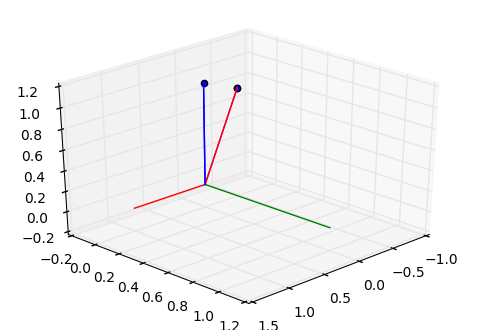

In [13]:
R=fs.rot_mat(v,[0,0,1])
vr=np.dot(R,v)
h=plot_axes_vec()
h.scatter(v[0],v[1],v[2])
h.plot([0,v[0]],[0,v[1]],[0,v[2]], color = 'r')
h.scatter(vr[0],vr[1],vr[2])
h.plot([0,vr[0]],[0,vr[1]],[0,vr[2]], color = 'b')
plt.show()

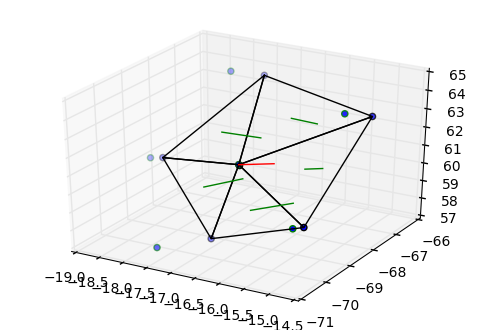

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.53986034e+00   7.23444021e-01   4.44089210e-16]
 [  1.17575105e+00   3.86496924e+00   1.55431223e-15]
 [  9.24591106e-02  -3.36291667e+00  -6.66133815e-16]
 [ -2.85660484e+00  -2.49683397e+00  -1.11022302e-15]
 [ -1.53150580e+00   1.53046552e+00   2.77555756e-16]]


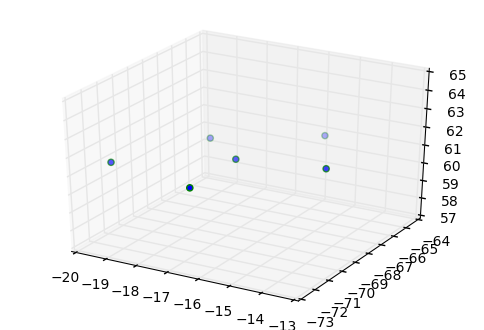

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.87947101e+00   1.85522250e+00   1.11022302e-16]
 [ -8.26753968e-01   3.95434642e+00   6.66133815e-16]
 [  1.69752859e+00  -2.90450579e+00   0.00000000e+00]
 [ -1.30481064e+00  -3.56256092e+00  -4.44089210e-16]
 [ -2.07862826e+00   6.05920219e-01   1.66533454e-16]]


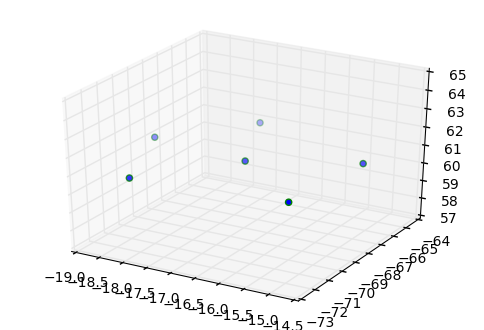

7.23460818618
[        nan  2.64088277  4.03984873  3.36418745  3.79399145  2.16514081]


In [25]:
# Testing normals and projections

nv=1 # Select vertice
fname=opj(subjects_dir,'fsaverage5','surf','lh.pial')
faces,position=fs.read_surf(fname)
vertices=np.where(np.sum(faces==nv,axis=1)>=1)[0]

fig = plt.figure()
ax  = fig.add_subplot(111, projection = '3d')

faces_ind=np.where(np.sum(faces==nv,axis=1)>=1)[0] # Extract rows for each faces containing the current vertice
pts=np.unique(faces[faces_ind,:])

# Plot triangles contour
for nf in faces_ind:
    x=position[faces[nf,[0,1,2,0]],0]
    y=position[faces[nf,[0,1,2,0]],1]
    z=position[faces[nf,[0,1,2,0]],2]
    ax.plot(x,y,z, color = 'k')
    
# Plot points
ax.scatter(position[pts,0], position[pts,1], position[pts,2])
ax.scatter(position[nv,0], position[nv,1], position[nv,2],c='r')

# Plot normals
midface=np.ndarray([3,len(faces)])
fnorm=np.ndarray([3,len(faces_ind)])

for nf,nn in zip(faces_ind,np.arange(0,len(faces_ind))):
    ind=np.where(faces[nf,:]==nv)[0]
    if ind==0:
        fnorm[:,nn]=np.cross(position[faces[nf,2],:]-position[faces[nf,0],:],
                    position[faces[nf,1],:]-position[faces[nf,0],:])
    elif ind==1:
        fnorm[:,nn]=np.cross(position[faces[nf,0],:]-position[faces[nf,1],:],
                        position[faces[nf,2],:]-position[faces[nf,1],:])
    elif ind==2:
        fnorm[:,nn]=np.cross(position[faces[nf,1],:]-position[faces[nf,2],:],
                        position[faces[nf,0],:]-position[faces[nf,2],:])
    midface[:,nn]=position[faces[nf,:],:].mean(axis=0)

fnorm=fnorm/np.linalg.norm(fnorm,axis=0)
        
for nf in np.arange(0,len(faces_ind)):
    x=[midface[0,nf],midface[0,nf]+fnorm[0,nf]];
    y=[midface[1,nf],midface[1,nf]+fnorm[1,nf]];
    z=[midface[2,nf],midface[2,nf]+fnorm[2,nf]];
    ax.plot(x,y,z, color = 'g')

mfnorm=fnorm.mean(axis=1)
mfnorm=mfnorm/np.linalg.norm(mfnorm)
x=[position[nv,0],position[nv,0]+mfnorm[0]];
y=[position[nv,1],position[nv,1]+mfnorm[1]];
z=[position[nv,2],position[nv,2]+mfnorm[2]];
ax.plot(x,y,z,color = 'r')

# Compute and plot project of each point onto the normal plane
proj_pts=np.zeros([len(pts),3])
px=position[pts,:]-position[nv,:]
for pt in np.where(pts!=nv)[0]:
    proj_pts[pt,:]=(px[pt,:]-np.dot(px[pt,:],mfnorm)*mfnorm)
    proj_pts[pt,:]=proj_pts[pt,:]*(fs.norm_arclen(px[pt,:],mfnorm)
                                   /np.linalg.norm(proj_pts[pt,:]))
x=position[nv,0]+proj_pts[:,0];
y=position[nv,1]+proj_pts[:,1];
z=position[nv,2]+proj_pts[:,2];
ax.scatter(x,y,z,color = 'g')
plt.show()

# Find rotation of normal vector onto z-axis
ez=np.array([0.,0.,1.])
# Rotate along x-axis
ax=fs.vec_angle(ez,np.array([0,mfnorm[1],mfnorm[2]]))
if mfnorm[1]<0:
    ax=-ax
# Rotate along y-axis
vrx,Rx=fs.rotate3d(mfnorm,ax,axis=0,compute=True,matrix=True)
ay=fs.vec_angle(ez,vrx)
if vrx[0]>0:
    ay=-ay
vz,Ry=fs.rotate3d(vrx,ay,axis=1,compute=True,matrix=True)

# For sanity, check that snorm was well projected onto z-axis
if (not math.isclose(vz[0],0.0, abs_tol=1e-9) or not math.isclose(vz[1],0.0, abs_tol=1e-9) or not
    math.isclose(vz[2],1.0, abs_tol=1e-9)):
    print(vz)
    raise ValueError('Normal vector was not well projected onto z-axis')
    
proj2=np.transpose(np.dot(np.dot(Ry,Rx),proj_pts.T))[:,[0,1]] # 2d matrix with rows as points and columns as x and y

R=fs.rot_mat(mfnorm,[0,0,1])
proj=np.dot(R,proj_pts.T).T
# proj=np.transpose(np.dot(np.dot(Ry,Rx),proj_pts.T))
print(proj)

fig = plt.figure()
ax  = fig.add_subplot(111, projection = '3d')
x=position[nv,0]+proj[:,0];
y=position[nv,1]+proj[:,1];
z=position[nv,2]+proj[:,2];
ax.scatter(x,y,z,color = 'g')
plt.show()

proj3=np.transpose(np.dot(np.dot(Ry,Rx),proj_pts.T))
print(proj3)

fig = plt.figure()
ax  = fig.add_subplot(111, projection = '3d')
x=position[nv,0]+proj3[:,0];
y=position[nv,1]+proj3[:,1];
z=position[nv,2]+proj3[:,2];
ax.scatter(x,y,z,color = 'g')
plt.show()

print(np.linalg.norm(px))
print(np.apply_along_axis(fs.norm_arclen,1,px,mfnorm))

In [17]:
R=fs.rot_mat(mfnorm,[0,0,1])

In [22]:
np.dot(R,proj_pts.T).T

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.53986034e+00,   7.23444021e-01,   4.44089210e-16],
       [  1.17575105e+00,   3.86496924e+00,   1.55431223e-15],
       [  9.24591106e-02,  -3.36291667e+00,  -6.66133815e-16],
       [ -2.85660484e+00,  -2.49683397e+00,  -1.11022302e-15],
       [ -1.53150580e+00,   1.53046552e+00,   2.77555756e-16]])